### Inverse Dynamics of Franka Emika `Panda`

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import mujoco_py
from mujoco_parser import MuJoCoParserClass
from util import get_colors
print ("Done.")

Done.


### Free-fall motion

In [2]:
env = MuJoCoParserClass(name='Panda',rel_xml_path='../asset/panda/franka_panda.xml',VERBOSE=False)
env.init_viewer(TERMINATE_GLFW=False,INITIALIZE_GLFW=True,window_width=0.5,window_height=0.5)
env.set_max_sec(max_sec=5.0)
# Buffers
sec_list = np.zeros(env.max_tick)
q_list   = np.zeros((env.max_tick,env.n_rev_joint))
env.reset()
while env.IS_ALIVE():
    torque = np.zeros(env.n_rev_joint) # zero torque
    env.step(ctrl=torque,ctrl_idxs=env.rev_joint_idxs) # torque applied to revolute joints
    env.render(render_speedup=1.0,RENDER_ALWAYS=False)
    env.print(print_every_sec=1.0,VERBOSE=1)
    # Append
    sec_list[env.tick-1] = env.get_sec_sim()
    q_list[env.tick-1,:] = env.get_q_pos(q_pos_idxs=env.rev_joint_idxs)
env.terminate_viewer()
env.sleep(1.0)
print ("Done.")

Creating window glfw
tick:[1/2500], sec_wall:[0.002]sec, sec_sim:[0.002]sec
tick:[500/2500], sec_wall:[0.836]sec, sec_sim:[1.000]sec
tick:[1000/2500], sec_wall:[1.814]sec, sec_sim:[2.000]sec
tick:[1500/2500], sec_wall:[2.825]sec, sec_sim:[3.000]sec
tick:[2000/2500], sec_wall:[3.845]sec, sec_sim:[4.000]sec
tick:[2500/2500], sec_wall:[4.869]sec, sec_sim:[5.000]sec
Done.


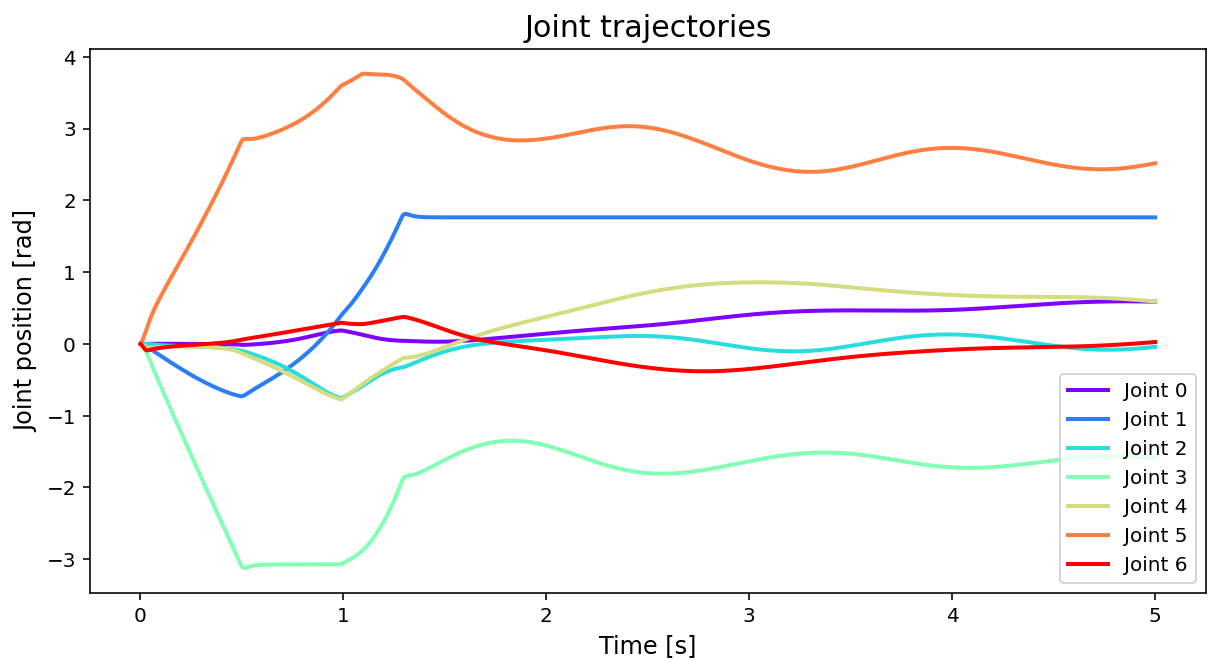

In [3]:
plt.figure(figsize=(10,5))
colors = get_colors(n=env.n_rev_joint)
for i_idx in range(env.n_rev_joint):
    plt.plot(sec_list,q_list[:,i_idx],'-',color=colors[i_idx],lw=2,label='Joint %d'%(i_idx))
plt.xlabel('Time [s]',fontsize=12)
plt.ylabel('Joint position [rad]',fontsize=12)
plt.legend(loc='lower right')
plt.title('Joint trajectories',fontsize=15)
plt.show()

### Gravity compensation

In [6]:
env = MuJoCoParserClass(name='Panda',rel_xml_path='../asset/panda/franka_panda.xml',VERBOSE=False)
env.init_viewer(TERMINATE_GLFW=False,INITIALIZE_GLFW=True,window_width=0.5,window_height=0.5)
env.set_max_sec(max_sec=5.0)

# Set initial manipulator position 
q_des = np.array([0,0,0,-90,0,90,0])*np.pi/180.0 # desired position
env.forward(q_pos=q_des,q_pos_idxs=env.rev_joint_idxs)
# Buffers
sec_list    = np.zeros(env.max_tick)
q_list      = np.zeros((env.max_tick,env.n_rev_joint))
torque_list = np.zeros((env.max_tick,env.n_rev_joint))
env.reset()
while env.IS_ALIVE():    
    # Backup 
    qpos_bu = env.sim.data.qpos[env.rev_joint_idxs]
    qvel_bu = env.sim.data.qvel[env.rev_joint_idxs]
    qacc_bu = env.sim.data.qacc[env.rev_joint_idxs]
    # Compute torque for gravity compensation by solving inverse dynamics
    q_rev = env.get_q_pos(q_pos_idxs=env.rev_joint_idxs)
    env.sim.data.qpos[env.rev_joint_idxs] = q_rev
    env.sim.data.qvel[env.rev_joint_idxs] = np.zeros(env.n_rev_joint)
    env.sim.data.qacc[env.rev_joint_idxs] = np.zeros(env.n_rev_joint)
    mujoco_py.functions.mj_inverse(env.sim.model,env.sim.data)
    torque = env.sim.data.qfrc_inverse[env.rev_joint_idxs].copy()
    # Restore
    env.sim.data.qpos[env.rev_joint_idxs] = qpos_bu
    env.sim.data.qvel[env.rev_joint_idxs] = qvel_bu
    env.sim.data.qacc[env.rev_joint_idxs] = qacc_bu
    # Step
    env.step(ctrl=1.0*torque,ctrl_idxs=env.rev_joint_idxs) # torque applied to revolute joints
    env.render(render_speedup=1.0,RENDER_ALWAYS=False)
    env.print(print_every_sec=1.0,VERBOSE=1)
    # Append
    sec_list[env.tick-1]      = env.get_sec_sim()
    q_list[env.tick-1,:]      = env.get_q_pos(q_pos_idxs=env.rev_joint_idxs)
    torque_list[env.tick-1,:] = torque
env.terminate_viewer()
env.sleep(1.0)
print ("Done.")    

Creating window glfw
tick:[1/2500], sec_wall:[0.126]sec, sec_sim:[0.002]sec
tick:[500/2500], sec_wall:[0.890]sec, sec_sim:[1.000]sec
tick:[1000/2500], sec_wall:[1.894]sec, sec_sim:[2.000]sec
tick:[1500/2500], sec_wall:[2.932]sec, sec_sim:[3.000]sec
tick:[2000/2500], sec_wall:[3.973]sec, sec_sim:[4.000]sec
tick:[2500/2500], sec_wall:[4.998]sec, sec_sim:[5.000]sec
Done.


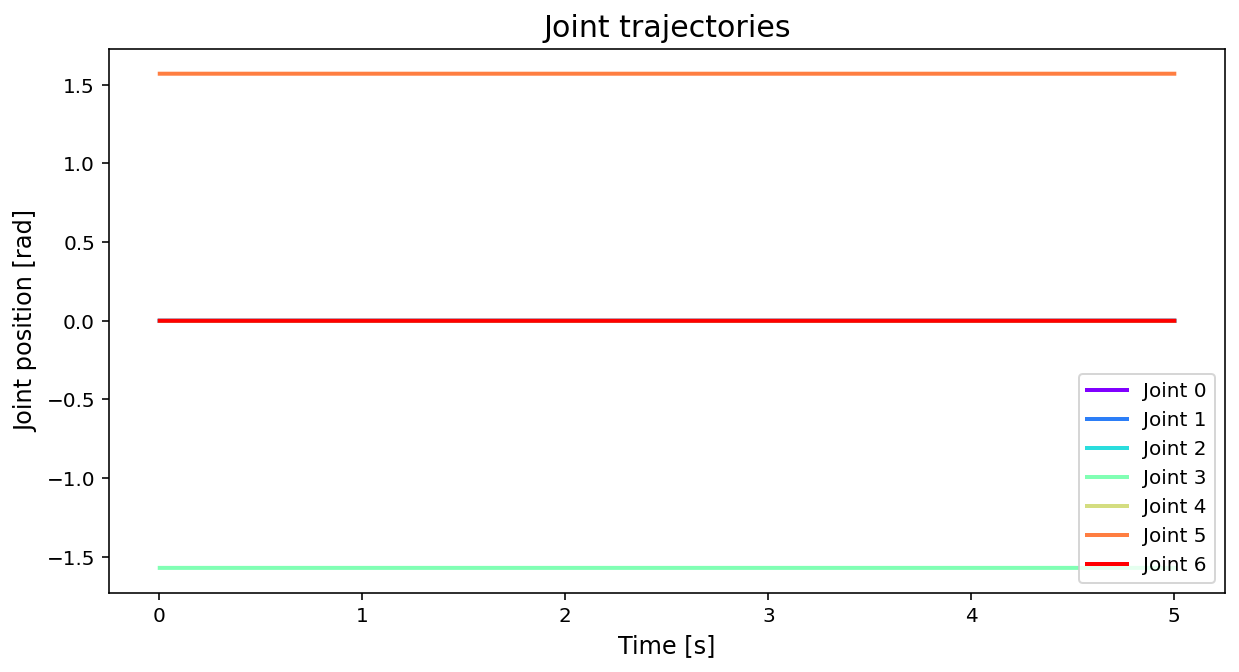

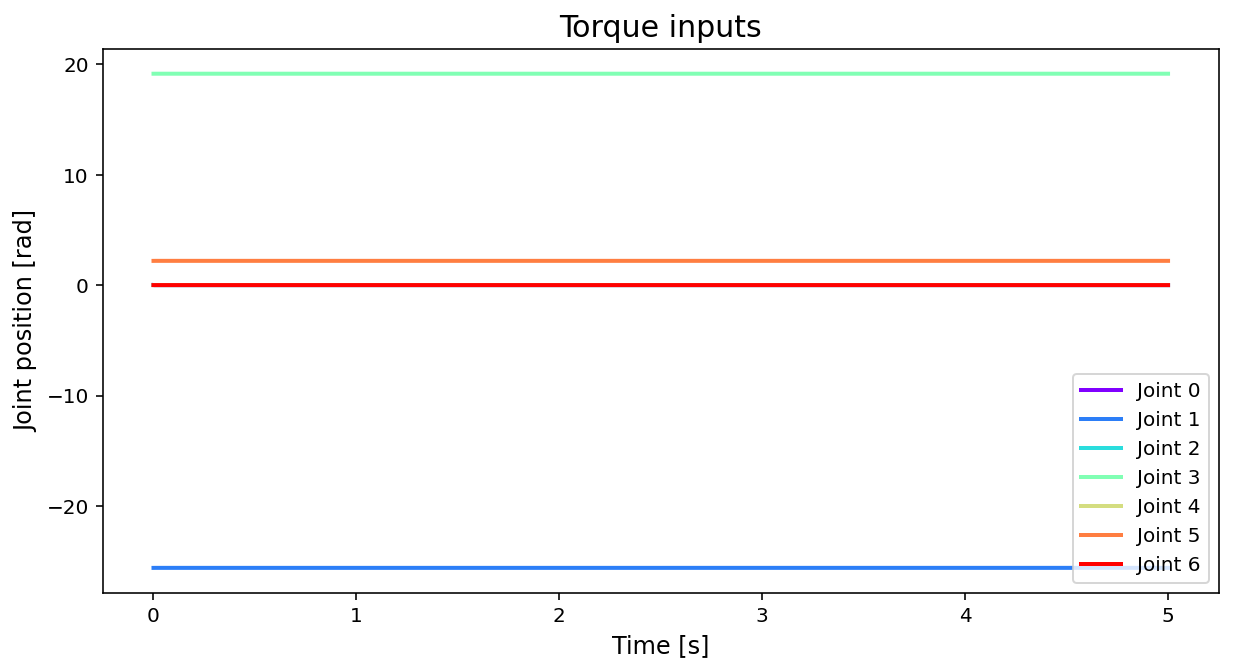

In [7]:
plt.figure(figsize=(10,5))
colors = get_colors(n=env.n_rev_joint)
for i_idx in range(env.n_rev_joint):
    plt.plot(sec_list,q_list[:,i_idx],'-',color=colors[i_idx],lw=2,label='Joint %d'%(i_idx))
plt.xlabel('Time [s]',fontsize=12)
plt.ylabel('Joint position [rad]',fontsize=12)
plt.legend(loc='lower right')
plt.title('Joint trajectories',fontsize=15)
plt.show()

plt.figure(figsize=(10,5))
colors = get_colors(n=env.n_rev_joint)
for i_idx in range(env.n_rev_joint):
    plt.plot(sec_list,torque_list[:,i_idx],'-',color=colors[i_idx],lw=2,label='Joint %d'%(i_idx))
plt.xlabel('Time [s]',fontsize=12)
plt.ylabel('Joint position [rad]',fontsize=12)
plt.legend(loc='lower right')
plt.title('Torque inputs',fontsize=15)
plt.show()

### Spring-like behavior

In [8]:
env = MuJoCoParserClass(name='Panda',rel_xml_path='../asset/panda/franka_panda.xml',VERBOSE=False)
env.init_viewer(TERMINATE_GLFW=False,INITIALIZE_GLFW=True,window_width=0.5,window_height=0.5)
env.set_max_sec(max_sec=5.0)

# Set initial manipulator position 
q_des = np.array([0,0,0,-90,0,90,0])*np.pi/180.0 # desired position
env.forward(q_pos=q_des+10.0*np.random.randn(env.n_rev_joint)*np.pi/180.0,q_pos_idxs=env.rev_joint_idxs)
# Buffers
sec_list    = np.zeros(env.max_tick)
q_list      = np.zeros((env.max_tick,env.n_rev_joint))
torque_list = np.zeros((env.max_tick,env.n_rev_joint))
env.reset()
while env.IS_ALIVE():    
    # Backup 
    qpos_bu = env.sim.data.qpos[env.rev_joint_idxs]
    qvel_bu = env.sim.data.qvel[env.rev_joint_idxs]
    qacc_bu = env.sim.data.qacc[env.rev_joint_idxs]
    # Compute torque for gravity compensation by solving inverse dynamics
    q_rev = env.get_q_pos(q_pos_idxs=env.rev_joint_idxs)
    q_err = q_des-q_rev
    env.sim.data.qpos[env.rev_joint_idxs] = q_rev
    env.sim.data.qvel[env.rev_joint_idxs] = np.zeros(env.n_rev_joint)
    env.sim.data.qacc[env.rev_joint_idxs] = 20.0*q_err
    mujoco_py.functions.mj_inverse(env.sim.model,env.sim.data)
    torque = env.sim.data.qfrc_inverse[env.rev_joint_idxs].copy()
    # Restore
    env.sim.data.qpos[env.rev_joint_idxs] = qpos_bu
    env.sim.data.qvel[env.rev_joint_idxs] = qvel_bu
    env.sim.data.qacc[env.rev_joint_idxs] = qacc_bu
    # Step
    env.step(ctrl=torque,ctrl_idxs=env.rev_joint_idxs) # torque applied to revolute joints
    env.render(render_speedup=1.0,RENDER_ALWAYS=False)
    env.print(print_every_sec=1.0,VERBOSE=1)
    # Append
    sec_list[env.tick-1]      = env.get_sec_sim()
    q_list[env.tick-1,:]      = env.get_q_pos(q_pos_idxs=env.rev_joint_idxs)
    torque_list[env.tick-1,:] = torque
env.terminate_viewer()
env.sleep(1.0)
print ("Done.")    

Creating window glfw
tick:[1/2500], sec_wall:[0.122]sec, sec_sim:[0.002]sec
tick:[500/2500], sec_wall:[0.888]sec, sec_sim:[1.000]sec
tick:[1000/2500], sec_wall:[1.904]sec, sec_sim:[2.000]sec
tick:[1500/2500], sec_wall:[2.954]sec, sec_sim:[3.000]sec
tick:[2000/2500], sec_wall:[3.976]sec, sec_sim:[4.000]sec
tick:[2500/2500], sec_wall:[4.998]sec, sec_sim:[5.000]sec
Done.


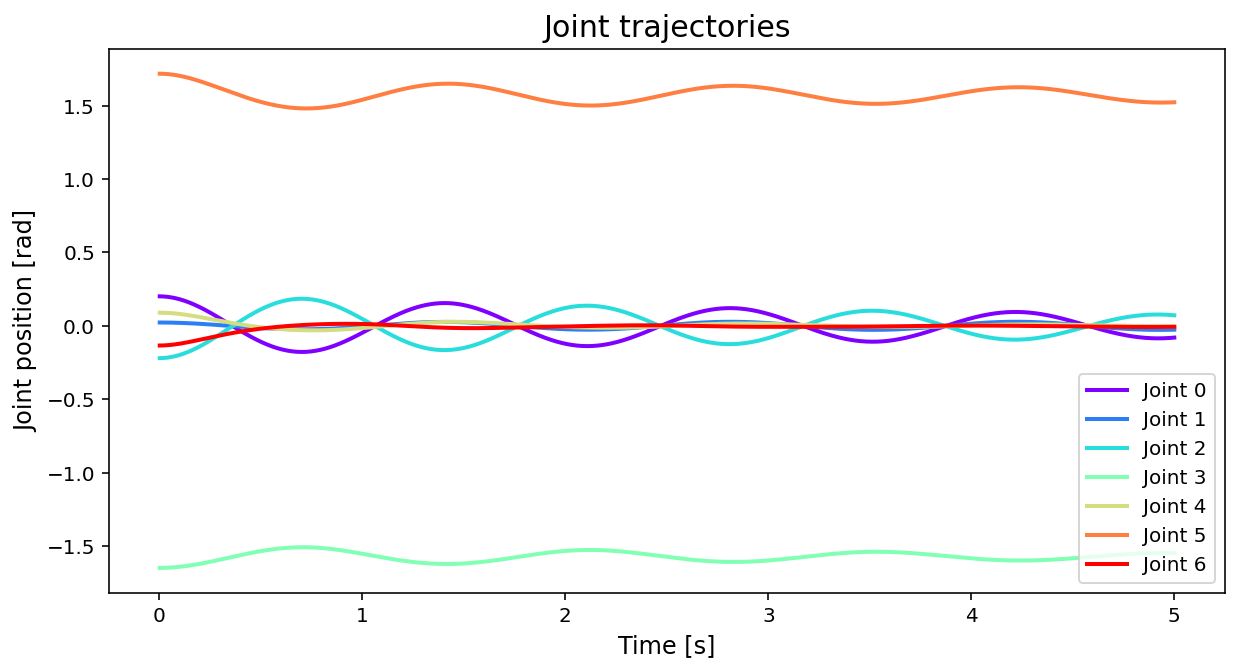

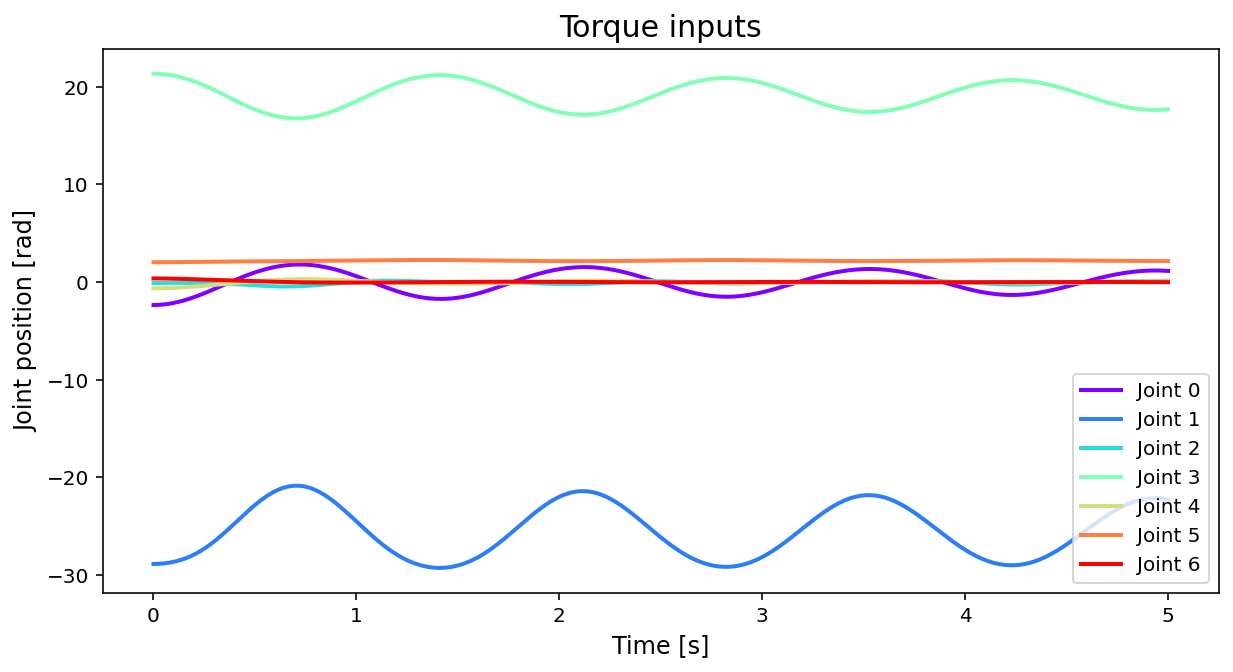

In [9]:
plt.figure(figsize=(10,5))
colors = get_colors(n=env.n_rev_joint)
for i_idx in range(env.n_rev_joint):
    plt.plot(sec_list,q_list[:,i_idx],'-',color=colors[i_idx],lw=2,label='Joint %d'%(i_idx))
plt.xlabel('Time [s]',fontsize=12)
plt.ylabel('Joint position [rad]',fontsize=12)
plt.legend(loc='lower right')
plt.title('Joint trajectories',fontsize=15)
plt.show()

plt.figure(figsize=(10,5))
colors = get_colors(n=env.n_rev_joint)
for i_idx in range(env.n_rev_joint):
    plt.plot(sec_list,torque_list[:,i_idx],'-',color=colors[i_idx],lw=2,label='Joint %d'%(i_idx))
plt.xlabel('Time [s]',fontsize=12)
plt.ylabel('Joint position [rad]',fontsize=12)
plt.legend(loc='lower right')
plt.title('Torque inputs',fontsize=15)
plt.show()